In [ ]:
# Install necessary libraries
!pip install -q kaggle tensorflow

import os
import matplotlib.image as mpimg
import shutil
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

In [ ]:
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
!kaggle datasets download -d aelchimminut/fruits262

import zipfile
!unzip fruits262.zip -d fruits262

# Set the path to the dataset
image_dir = "fruits262/Fruit-262"

Streaming output truncated to the last 5000 lines.
  inflating: fruits262/Resized_Fruits-262/104x128/acerola/369.jpg  
  inflating: fruits262/Resized_Fruits-262/104x128/acerola/37.jpg  
  inflating: fruits262/Resized_Fruits-262/104x128/acerola/370.jpg  
  inflating: fruits262/Resized_Fruits-262/104x128/acerola/371.jpg  
  inflating: fruits262/Resized_Fruits-262/104x128/acerola/372.jpg  
  inflating: fruits262/Resized_Fruits-262/104x128/acerola/373.jpg  
  inflating: fruits262/Resized_Fruits-262/104x128/acerola/374.jpg  
  inflating: fruits262/Resized_Fruits-262/104x128/acerola/375.jpg  
  inflating: fruits262/Resized_Fruits-262/104x128/acerola/376.jpg  
  inflating: fruits262/Resized_Fruits-262/104x128/acerola/377.jpg  
  inflating: fruits262/Resized_Fruits-262/104x128/acerola/378.jpg  
  inflating: fruits262/Resized_Fruits-262/104x128/acerola/379.jpg  
  inflating: fruits262/Resized_Fruits-262/104x128/acerola/38.jpg  
  inflating: fruits262/Resized_Fruits-262/104x128/acerola/380.jpg  

In [ ]:
#Finding all of the fruit classes
!ls fruits262/Fruit-262

 abiu		     'custard apple'	   lemon		 plumcot
 acai		      damson		  'lemon aspen'		 podocarpus
 acerola	      date		   leucaena		 pomegranate
 ackee		     'desert fig'	   lillipilli		 pomelo
'alligator apple'    'desert lime'	   lime			'prikly pear'
 ambarella	      dewberry		   lingonberry		 pulasan
 apple		      dragonfruit	   loganberry		 pumpkin
 apricot	      durian		   longan		 pupunha
 araza		      eggplant		   loquat		'purple apple berry'
 avocado	      elderberry	   lucuma		 quandong
 bael		     'elephant apple'	   lulo			 quince
 banana		      emblic		   lychee		 rambutan
 barbadine	      entawak		   mabolo		 rangpur
 barberry	      etrog		   macadamia		 raspberry
 bayberry	      feijoa		  'malay apple'		 redcurrant
'beach plum'	     'fibrous satinash'   'mamey apple'		'red mulberry'
 bearberry	      fig		   mandarine		 riberry
'bell pepper'	     'finger lime'	   mango		'ridged gourd'
'betel nut'	     'galia melon'	   mangosteen		 rimu
 bignay		      gandaria		  'manila tam

(183, 223, 3)

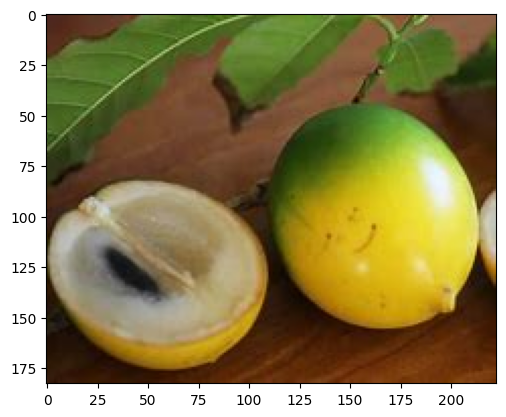

In [ ]:
#looking at an image in the dataset to figure out what we need to fix
img = mpimg.imread("fruits262/Fruit-262/abiu/69.jpg")
plt.imshow(img, cmap=plt.cm.gray)
img.shape

In [ ]:
base_output_dir = "Fruit_Datasets"
train_dir = os.path.join(base_output_dir, "train")
val_dir = os.path.join(base_output_dir, "val")
test_dir = os.path.join(base_output_dir, "test")

# Create directories if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Split data into train, validation, and test sets
image_paths = []
class_names = []
for subdir, dirs, files in os.walk(image_dir):
    for fname in files:
        if fname.endswith('jpg'):
            image_paths.append(os.path.join(subdir, fname))
            class_names.append(os.path.basename(subdir))

In [ ]:
# Shuffle and split into train, validation, and test datasets
train_val_paths, test_paths = train_test_split(image_paths, test_size=0.1, random_state=1337)
train_paths, val_paths = train_test_split(train_val_paths, test_size=0.1, random_state=1337)


In [ ]:
# Function to copy images to respective directories
def copy_images(image_paths, dest_dir):
    for image_path in image_paths:
        class_name = os.path.basename(os.path.dirname(image_path))
        class_dest_dir = os.path.join(dest_dir, class_name)
        os.makedirs(class_dest_dir, exist_ok=True)
        shutil.copy(image_path, class_dest_dir)

# Copy images to respective directories
copy_images(train_paths, train_dir)
copy_images(val_paths, val_dir)
copy_images(test_paths, test_dir)

# Load the datasets using image_dataset_from_directory
image_size = (64, 64)
batch_size = 16

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=image_size,
    batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    image_size=image_size,
    batch_size=batch_size
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=image_size,
    batch_size=batch_size
)

# Extract class names
class_names = train_ds.class_names
print("Class Names:", class_names)

# Prefetch for performance
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(tf.data.AUTOTUNE)

Found 182767 files belonging to 262 classes.
Found 20308 files belonging to 262 classes.
Found 22564 files belonging to 262 classes.
Class Names: ['abiu', 'acai', 'acerola', 'ackee', 'alligator apple', 'ambarella', 'apple', 'apricot', 'araza', 'avocado', 'bael', 'banana', 'barbadine', 'barberry', 'bayberry', 'beach plum', 'bearberry', 'bell pepper', 'betel nut', 'bignay', 'bilimbi', 'bitter gourd', 'black berry', 'black cherry', 'black currant', 'black mullberry', 'black sapote', 'blueberry', 'bolwarra', 'bottle gourd', 'brazil nut', 'bread fruit', "buddha's hand", 'buffaloberry', 'burdekin plum', 'burmese grape', 'caimito', 'camu camu', 'canistel', 'cantaloupe', 'cape gooseberry', 'carambola', 'cardon', 'cashew', 'cedar bay cherry', 'cempedak', 'ceylon gooseberry', 'che', 'chenet', 'cherimoya', 'cherry', 'chico', 'chokeberry', 'clementine', 'cloudberry', 'cluster fig', 'cocoa bean', 'coconut', 'coffee', 'common buckthorn', 'corn kernel', 'cornelian cherry', 'crab apple', 'cranberry', 

In [ ]:
# Prefetch data for performance optimization
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

# Data augmentation to increase dataset diversity
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2)
])

In [ ]:
# Define the CNN model architecture with input shape defined in the first layer
model = tf.keras.Sequential([
    # First layer should have an explicit input shape
    tf.keras.layers.Rescaling(1./63, input_shape=(64, 64, 3)),  # Rescaling image to [0, 1]
    tf.keras.layers.RandomFlip("horizontal"),  # Data augmentation
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),

    # Convolutional layers and pooling layers
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Flatten layer to convert 2D to 1D
    tf.keras.layers.Flatten(),

    # Dense layers for classification
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(len(class_names), activation='softmax')  # Output layer
])



/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',  # Using sparse because labels are integers
    metrics=['accuracy'])

In [ ]:
# Set up early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
# Train the model
history = model.fit(
    train_ds,
    epochs=25,
    validation_data=val_ds,
    callbacks=[early_stopping]
)

Epoch 1/25
11423/11423 ━━━━━━━━━━━━━━━━━━━━ 191s 17ms/step - accuracy: 0.0450 - loss: 4.6344 - val_accuracy: 0.1010 - val_loss: 4.1315
Epoch 2/25
11423/11423 ━━━━━━━━━━━━━━━━━━━━ 169s 14ms/step - accuracy: 0.1099 - loss: 4.0326 - val_accuracy: 0.1378 - val_loss: 3.8665
Epoch 3/25
11423/11423 ━━━━━━━━━━━━━━━━━━━━ 200s 14ms/step - accuracy: 0.1371 - loss: 3.8613 - val_accuracy: 0.1474 - val_loss: 3.8253
Epoch 4/25
11423/11423 ━━━━━━━━━━━━━━━━━━━━ 203s 14ms/step - accuracy: 0.1520 - loss: 3.7729 - val_accuracy: 0.1620 - val_loss: 3.7470
Epoch 5/25
11423/11423 ━━━━━━━━━━━━━━━━━━━━ 198s 13ms/step - accuracy: 0.1629 - loss: 3.7109 - val_accuracy: 0.1719 - val_loss: 3.6946
Epoch 6/25
11423/11423 ━━━━━━━━━━━━━━━━━━━━ 203s 13ms/step - accuracy: 0.1726 - loss: 3.6555 - val_accuracy: 0.1486 - val_loss: 3.9137
Epoch 7/25
11423/11423 ━━━━━━━━━━━━━━━━━━━━ 202s 13ms/step - accuracy: 0.1794 - loss: 3.6180 - val_accuracy: 0.1627 - val_loss: 3.7784
Epoch 8/25
11423/11423 ━━━━━━━━━━━━━━━━━━━━ 203s 14ms/s

In [ ]:
from tensorflow.keras import mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

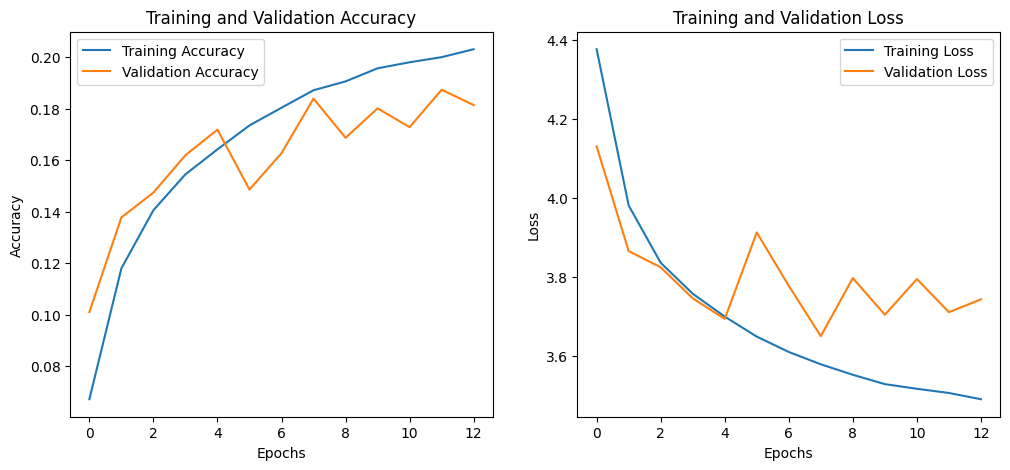

In [ ]:
# Plot Accuracy and Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
import tensorflow as tf
import numpy as np

# Evaluate the model on the test dataset in smaller chunks
# Get the total number of samples by iterating through the dataset
num_samples = sum(len(batch[0]) for batch in test_ds)

batch_size = 16  # Reduced batch size

# Create a new dataset with the reduced batch size
test_ds_reduced = test_ds.unbatch().batch(batch_size)

loss_total = 0
acc_total = 0
count = 0

# Process the dataset in chunks
for images, labels in test_ds_reduced:
    loss, acc = model.evaluate(images, labels, verbose=0)
    loss_total += loss
    acc_total += acc
    count += 1

# Calculate average loss and accuracy
avg_loss = loss_total / count
avg_acc = acc_total / count

print(f"Test Accuracy: {avg_acc:.2f}, Test Loss: {avg_loss:.2f}")

Test Accuracy: 0.18, Test Loss: 3.78


Displaying predictions from a batch:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


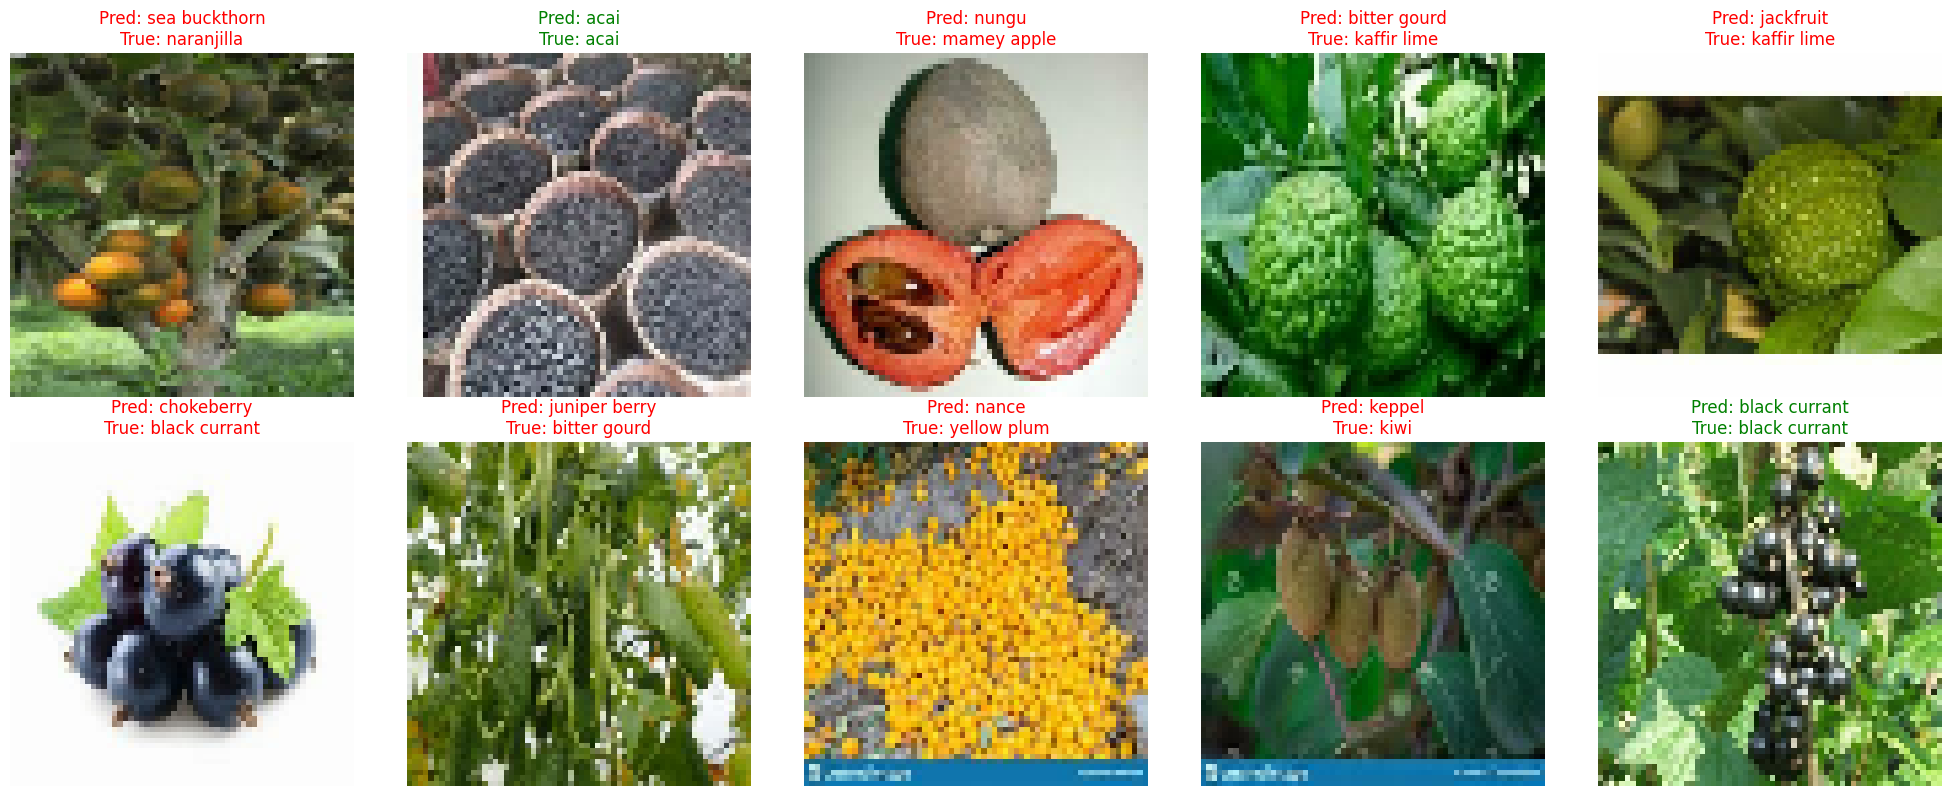

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Function to display random predictions
def display_predictions_from_batch(model, test_dataset, class_names, num_images=10):
    """
    Displays random predictions for a batch of images from the test dataset.

    Args:
        model: Trained TensorFlow/Keras model.
        test_dataset: Batched test dataset.
        class_names: List of class names.
        num_images: Number of images to display.
    """
    # Take one batch from the test dataset
    for images, labels in test_dataset.take(1):
        predictions = model.predict(images)  # Get predictions for the batch
        predicted_classes = np.argmax(predictions, axis=1)

        # Randomly select a subset of images
        indices = np.random.choice(len(images), num_images, replace=False)

        # Plot the selected images
        plt.figure(figsize=(20, 8))
        for i, idx in enumerate(indices):
            ax = plt.subplot(2, 5, i + 1)
            plt.imshow(images[idx].numpy().astype("uint8"))  # Display image

            # Get predicted and true labels
            pred_label = class_names[predicted_classes[idx]]
            true_label = class_names[labels[idx]]

            # Title color: green for correct, red for incorrect
            color = "green" if pred_label == true_label else "red"
            plt.title(f"Pred: {pred_label}\nTrue: {true_label}", color=color)
            plt.axis("off")

        plt.tight_layout()
        plt.show()
        break  # Exit after processing one batch

# Display predictions from a batch
print("Displaying predictions from a batch:")
display_predictions_from_batch(model, test_ds, class_names, num_images=10)



In [ ]:
import sys
from io import StringIO

# Save model
model.save('FruitClassification-Model.keras')

# Save model summary to a string
model_summary = StringIO()
model.summary(print_fn=lambda x: model_summary.write(x + '\n'))

# Save the summary to network.txt
with open("network.txt", "w") as f:
    f.write(model_summary.getvalue())


In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_flip_1 (RandomFlip)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation_1 (RandomRotation)   │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom_1 (RandomZoom)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 262)                 │          33,798 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,015,316 (38.21 MB)

 Trainable params: 3,338,438 (12.74 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,676,878 (25.47 MB)